# Part A: Dataset

### Introduction:
In this project, I built a simple NLP system to help organize and understand scientific texts about Alzheimer’s disease. The dataset I worked with contains publication titles and abstracts, and my goal was to turn these messy, unstructured paragraphs into something more structured and easier to review. First, I loaded the data and used basic regex rules to pull out three types of biological information: genetic variants (like rsIDs), gene names, and disease terms. After extracting these pieces, I put them into a clean table and also created a JSON file that includes each text’s key entities, a detected relation phrase, and the most relevant sentence as evidence. Once the extraction was working, I moved on to topic modeling to see how the abstracts naturally group together. I first used TF-IDF with K-means, and then tried another method, NMF, to compare the topic structures. Both approaches helped reveal what general themes appear across the papers, such as genetic risk, clinical studies, or methodology discussions. Overall, the project walks through a full pipeline: reading raw text, pulling out useful information, structuring it, and finally clustering the documents to understand their main topics.

### Import packages

In [1]:
from google.colab import files
import os, shutil
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

### Part 1.1: Upload Dataset

In [2]:
# get the working directory
work_dir = "/content/project"
os.makedirs(work_dir, exist_ok=True)

print("Please upload text.csv...")
uploaded = files.upload()

for fname in uploaded.keys():
    shutil.move(f"/content/{fname}", f"{work_dir}/{fname}")

os.chdir(work_dir)

df = pd.read_csv("text.csv", encoding="utf-8")
df.head()


Please upload text.csv...


Saving text.csv to text.csv


,text_id,Title,Abstract
0,T1,Translating Alzheimer's disease-associated pol...,The International Genomics of Alzheimer's Proj...
1,T2,Genetic heterogeneity of Alzheimer's disease i...,Alzheimer's disease (AD) is a progressive neur...
2,T3,Genome-wide meta-analysis identifies new loci ...,Alzheimer's disease (AD) is highly heritable a...
3,T4,Genetic meta-analysis of diagnosed Alzheimer's...,Risk for late-onset Alzheimer's disease (LOAD)...
4,T5,Identification of genetic heterogeneity of Alz...,The risk of **APOE** for Alzheimer's disease (...


### Part 1.2 : Extract the entity extraction

In [3]:
# create one function to find genetic variant IDs like rs12345 in the text.
def extract_variants(text):
    # if the cell is not a string (e.g. NaN), then we return empty list
    if not isinstance(text, str):
        return []
    # remove the space
    t = text.replace(" ", "")
    return re.findall(r"(?i)rs\d{3,12}", t)

# the words we do not want to treat as genes, even if they look like all-caps
blacklist = {"AD","GWAS","LOAD","CSF","DNA","RNA","APPROACH","METHOD","RESULTS","SNP","SNPs","IGAP","FDR","MRI","GRS","MCI"}

def extract_genes(text):
    if not isinstance(text, str):
        return []

    tokens = re.findall(r"\b(?=[A-Z0-9]{3,8}\b)[A-Z]*[A-Z][A-Z0-9]*\b", text)

    genes = []
    seen = set()
    for t in tokens:
        # skip if in blacklist or already added
        if t in blacklist:
            continue
        if t.isdigit():
            continue

        if t not in seen:
            seen.add(t)
            genes.append(t)

    return genes


# define the words that usually appear at the end of a disease phrase
disease_suffixes = {"disease","diseases","dementia","depression","diabetes","obesity","cancer","carcinoma","lymphoma",
                    "stroke","infarct","infarcts","sclerosis","syndrome","disorder","disorders","pathology"}

def extract_diseases(text):
    if not isinstance(text, str):
        return []
    # capture multi-word phrases made of letters/dashes:
    candidates = re.findall(r"\b[A-Za-z][A-Za-z\-]*(?:\s[A-Za-z][A-Za-z\-]*)*\b", text)

    diseases = []
    for c in candidates:
        words = c.split()
        last = words[-1].lower()

        # skip weird "'s disease" artifacts that sometimes appear as "s disease"
        if c.lower().startswith("s "):
            continue

        # remove fragments like "s disease", "as disease", etc.
        if len(words[0]) <= 2:
            continue
        # keep only phrases where the last word looks like a disease keyword
        if last in disease_suffixes:
            diseases.append(c)

    # remove duplicates while preserving order
    out = []
    seen = set()
    for d in diseases:
        if d not in seen:
            seen.add(d)
            out.append(d)
    return out

# run our functions on the "Abstract" text and store results in new columns
df["variants"] = df["Abstract"].apply(extract_variants)
df["genes"] = df["Abstract"].apply(extract_genes)
df["diseases"] = df["Abstract"].apply(extract_diseases)

df.head(20)


,text_id,Title,Abstract,variants,genes,diseases
0,T1,Translating Alzheimer's disease-associated pol...,The International Genomics of Alzheimer's Proj...,[],"[CELF1, MS4A6A, MYBPC3, DSG2, DLGAP1, NETO1, A...",[]
1,T2,Genetic heterogeneity of Alzheimer's disease i...,Alzheimer's disease (AD) is a progressive neur...,[],[],[]
2,T3,Genome-wide meta-analysis identifies new loci ...,Alzheimer's disease (AD) is highly heritable a...,[],[],[]
3,T4,Genetic meta-analysis of diagnosed Alzheimer's...,Risk for late-onset Alzheimer's disease (LOAD)...,[],"[IQCK, ACE, ADAM10, ADAMTS1, WWOX, HLA, DR15, ...",[the most prevalent dementia]
4,T5,Identification of genetic heterogeneity of Alz...,The risk of **APOE** for Alzheimer's disease (...,[],"[APOE, BIN1, OR2S2, MS4A4E, PICALM]",[]
5,T6,Dissecting the genetic relationship between ca...,**Cardiovascular (CV)- and lifestyle-associate...,[],"[APOE, BMI, T2D, CAD, WHR, LDL, HDL, MBLAC1, M...","[diabetes, coronary artery disease]"
6,T7,Shared genetic architecture between metabolic ...,A growing number of studies clearly demonstrat...,[],"[HDL, T2D, LDL]",[]
7,T8,Genetic Overlap Between Alzheimer's Disease an...,**Background**: Alzheimer's disease (AD) and *...,"[rs10792421, rs11649476]","[BIP, MARK2, VAC14]",[bipolar disorder]
8,T9,Genome-wide analysis of genetic predisposition...,**Background**: Alzheimer's disease (AD) is th...,[],[],[]
9,T10,Genetic and lifestyle risk factors for MRI-def...,**Objective**: To explore genetic and lifestyl...,[],"[SSBI, SBBI, FBN2, ZDHHC20]","[MRI-defined brain infarcts, diabetes, previou..."


### Part 1.3: Extract the results

In [4]:
# create an empty list to store processed rows
rows = []

for _, row in df.iterrows():
    tid = row["text_id"]
    title = row["Title"]

    # these columns contain the extracted entities from earlier steps
    variants = row["variants"]
    genes = row["genes"]
    diseases = row["diseases"]
    # keep a single representative entity, otherwise store None
    rows.append({
        "text_id": tid,
        "title": title,
        "variant": variants if isinstance(variants, list) and len(variants) > 0 else None,
        "gene": genes if isinstance(genes, list) and len(genes) > 0 else None,
        "disease": diseases if isinstance(diseases, list) and len(diseases) > 0 else None
    })
# convert our list of dictionaries into a DataFrame for easy processing
structured = pd.DataFrame(rows)
structured.head(20)


,text_id,title,variant,gene,disease
0,T1,Translating Alzheimer's disease-associated pol...,None,"[CELF1, MS4A6A, MYBPC3, DSG2, DLGAP1, NETO1, A...",None
1,T2,Genetic heterogeneity of Alzheimer's disease i...,None,None,None
2,T3,Genome-wide meta-analysis identifies new loci ...,None,None,None
3,T4,Genetic meta-analysis of diagnosed Alzheimer's...,None,"[IQCK, ACE, ADAM10, ADAMTS1, WWOX, HLA, DR15, ...",[the most prevalent dementia]
4,T5,Identification of genetic heterogeneity of Alz...,None,"[APOE, BIN1, OR2S2, MS4A4E, PICALM]",None
5,T6,Dissecting the genetic relationship between ca...,None,"[APOE, BMI, T2D, CAD, WHR, LDL, HDL, MBLAC1, M...","[diabetes, coronary artery disease]"
6,T7,Shared genetic architecture between metabolic ...,None,"[HDL, T2D, LDL]",None
7,T8,Genetic Overlap Between Alzheimer's Disease an...,"[rs10792421, rs11649476]","[BIP, MARK2, VAC14]",[bipolar disorder]
8,T9,Genome-wide analysis of genetic predisposition...,None,None,None
9,T10,Genetic and lifestyle risk factors for MRI-def...,None,"[SSBI, SBBI, FBN2, ZDHHC20]","[MRI-defined brain infarcts, diabetes, previou..."


### Part 1.4: TF-IDF & Fit the K-means

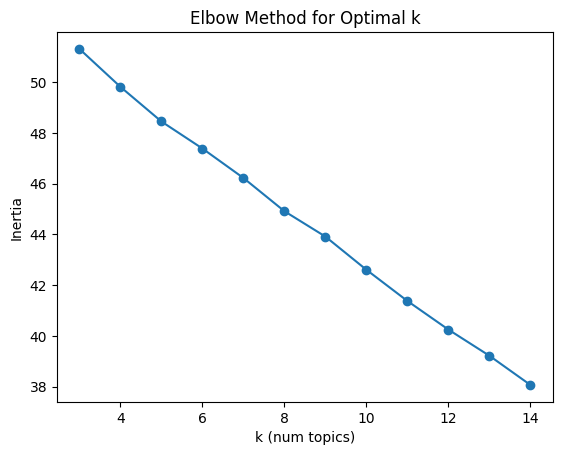

In [5]:
# extract the text from the DataFrame
texts = df["Abstract"].fillna("").tolist()
# design TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features = 5000, stop_words = "english", ngram_range = (1,2))
# convert text into TF-IDF matrix
X = vectorizer.fit_transform(texts)
# use the elbow method to pick the number of topics
inertias = []
K = range(3, 15)
# train K-means for each k and store the inertia value
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertias.append(km.inertia_)
# plot the inertia curve
plt.plot(K, inertias, marker='o')
plt.xlabel("k (num topics)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

Although the inertia decreases monotonically as k increases, the curve does not exhibit a clear elbow point where the rate of improvement sharply slows down. In such cases, the selection of k cannot be determined purely from the elbow method. Therefore, choosing k=5 or k=6 is based on practical considerations such as the desire to avoid overly fragmented clusters. This approach is consistent with common practice in topic modeling when the elbow plot does not show a distinct turning point.

In [6]:
# choose number of topics
k = 5
# fit the final K-means model
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(X)
# add topic assignments back to DataFrame
df["topic"] = labels
# write the function to print the top TF-IDF terms per topic
def top_terms(model, vectorizer, n=15):
    terms = vectorizer.get_feature_names_out()
    for i, center in enumerate(model.cluster_centers_):
        print(f"Topic {i}:")
        # find n highest-weight terms
        top_ids = center.argsort()[-n:]
        print(", ".join(terms[j] for j in top_ids))

top_terms(kmeans, vectorizer)

Topic 0:
ad bip, gene, rare, overlap, load, ad pd, associated, variants, bip, als, genetic, risk, ftd, pd, ad
Topic 1:
disease, association, loci, snps, apoe varepsilon, risk, age, associated, text, varepsilon, apoe, times 10, times, 10, ad
Topic 2:
associated, expression, analyses, health, association, associations, specific, t2d, snps, gwas, loci, genetic, genes, sex, ad
Topic 3:
datasets, csf tau, protein, protein levels, ykl 40, ykl, plasma, pap, blood, ccl16, snps, prolactin, levels, tau, csf
Topic 4:
cerebral, associated wmh, genetic, fa, wmhv, wmh volume, md, white, white matter, matter, intracranial, intracranial volume, volume, stroke, wmh


# Part B: Entity & Relation Extraction

### Part 2.1: Detect and label key entities and relations per text

In [7]:
# create the relation keywords
relation_keywords = ["associated with", "linked to", "correlated with", "increases risk of",
                     "decreases risk of", "affects", "regulates", "causes"]
# create the function to extract the relation
def extract_relation(text):
    if not isinstance(text, str):
        return None
    low = text.lower()
    for kw in relation_keywords:
        if kw in low:
            return kw
    return None

df["relation"] = df["Abstract"].apply(extract_relation)

### Part 2.2: Create a structured output table

In [8]:
nlp = spacy.load("en_core_web_sm")

# emphasize the list of relation phrases we care about
RELATION_PATTERNS = ["associated with","linked to","increases risk of","decreases risk of","correlated with",
                     "related to","affects","causes"]

# create the function to find a relation phrase anywhere in the abstract.
def find_relation(text: str):
    text_lower = text.lower()
    for rel in RELATION_PATTERNS:
        if rel in text_lower:
            return rel
    return None

# choose a sentence as the evidence span
# we only pick the sentences that best supports the variant–gene–phenotype link.
def find_evidence_sentence(abstract, variant, gene, phenotype):
    # if we have no entities, we can't really define evidence
    if not variant and not gene and not phenotype:
        return None

    doc = nlp(abstract)
    sentences = [sent.text for sent in doc.sents]

    best_sent = None
    best_score = 0

    for sent in sentences:
        s = sent.lower()

        # we need to test that whether this sentence contain each entity
        has_var  = bool(variant and str(variant).lower() in s)
        has_gene = bool(gene and str(gene).lower() in s)
        has_ph   = bool(phenotype and str(phenotype).lower() in s)

        # we set one base score: how many different entities appear here?
        score = int(has_var) + int(has_gene) + int(has_ph)

        # bonus if the sentence contains a relation phrase
        if any(rel in s for rel in RELATION_PATTERNS):
            score += 1

        # keep best-scoring sentence
        if score > best_score:
            best_score = score
            best_sent = sent

    # If no sentence has enough signal, return None to avoid misleading spans
    if best_score < 2:
        return None

    return best_sent

# build curated records from our DataFrame
curated_records = []

for _, row in df.iterrows():
    abstract = row["Abstract"]

    # ensure we always have lists for the three entity types
    variants = row["variants"] if isinstance(row["variants"], list) else []
    genes = row["genes"] if isinstance(row["genes"], list) else []
    diseases = row["diseases"] if isinstance(row["diseases"], list) else []

    # take the first entity of each type due to the simplicity
    variant = variants[0] if variants else None
    gene = genes[0] if genes else None
    phenotype = diseases[0] if diseases else None

    # find a simple relation phrase in the text
    relation = find_relation(abstract)

    # pick a short evidence span supporting this triple
    evidence_span = find_evidence_sentence(abstract, variant, gene, phenotype)

    curated_records.append({
        "text_id": row["text_id"],
        "title":   row["Title"],
        "variant": variant,
        "gene":    gene,
        "phenotype": phenotype,
        "relation": relation,
        "evidence_span": evidence_span
    })

# save everything to JSON
with open("curated_output.json", "w", encoding="utf-8") as f:
    json.dump(curated_records, f, indent=2, ensure_ascii=False)

curated_records[:30]

[{'text_id': 'T1',
  'title': "Translating Alzheimer's disease-associated polymorphisms into functional candidates: a survey of IGAP genes and SNPs",
  'variant': None,
  'gene': 'CELF1',
  'phenotype': None,
  'relation': 'associated with',
  'evidence_span': 'For (2), the IGAP SNPs in **CELF1** and **MS4A6A** were associated with expression of their neighboring genes, **MYBPC3** and **MS4A6A**, respectively, in blood.'},
 {'text_id': 'T2',
  'title': "Genetic heterogeneity of Alzheimer's disease in subjects with and without hypertension",
  'variant': None,
  'gene': None,
  'phenotype': None,
  'relation': 'associated with',
  'evidence_span': None},
 {'text_id': 'T3',
  'title': "Genome-wide meta-analysis identifies new loci and functional pathways influencing Alzheimer's disease risk",
  'variant': None,
  'gene': None,
  'phenotype': None,
  'relation': None,
  'evidence_span': None},
 {'text_id': 'T4',
  'title': "Genetic meta-analysis of diagnosed Alzheimer's disease identifies

# Part C: Topic Grouping / Clustering

### Part 3.1: NMF topic modelling

In [9]:
# re-create TF-IDF matrix
texts = df["Abstract"].fillna("").tolist()
# only unigrams this time
vectorizer_nmf = TfidfVectorizer(stop_words="english", max_features=5000)
X_nmf = vectorizer_nmf.fit_transform(texts)
# vocabulary list for printing topic words later
terms_nmf = vectorizer_nmf.get_feature_names_out()

# Fit NMF with the same number of topics (5)
nmf = NMF(n_components=5, random_state=42)
# create document–topic matrix (W) and topic–term matrix (H)
W = nmf.fit_transform(X_nmf)
H = nmf.components_
# for each document, assign the topic with the highest weight
df["topic_nmf"] = W.argmax(axis=1)

# print top words per NMF topic
for i, topic_vec in enumerate(H):
    top_ids = topic_vec.argsort()[-10:]
    print(f"\nNMF Topic {i}")
    print([terms_nmf [j] for j in top_ids])


NMF Topic 0
['gene', 'disease', 'expression', 'risk', 'snps', 'associated', 'loci', 'genetic', 'genes', 'ad']

NMF Topic 1
['ykl', 'plasma', 'beta', 'clu', '40', '42', 'levels', 'beta_', 'tau', 'csf']

NMF Topic 2
['stage', 'risk', 'effects', 'ad', 'aoo', 'times', '10', 'age', 'apoe', 'varepsilon']

NMF Topic 3
['sharpin', 'genetic', 'cerebral', 'white', 'cognitive', 'matter', 'svd', 'volume', 'stroke', 'wmh']

NMF Topic 4
['interactions', 'endophenotypes', 'stratified', 'analyses', 'previous', 'associations', 'females', 'males', 'specific', 'sex']


In [10]:
# rename
df = df.rename(columns={'topic': 'topic_kmeans'})

### Part 3.2: Comparison & visualization

In [11]:
# compare how K-means topics vs NMF topics line up for a few papers
df[["text_id", "Title", "topic_kmeans", "topic_nmf"]].head(15)

,text_id,Title,topic_kmeans,topic_nmf
0,T1,Translating Alzheimer's disease-associated pol...,1,0
1,T2,Genetic heterogeneity of Alzheimer's disease i...,2,4
2,T3,Genome-wide meta-analysis identifies new loci ...,2,0
3,T4,Genetic meta-analysis of diagnosed Alzheimer's...,0,0
4,T5,Identification of genetic heterogeneity of Alz...,1,2
5,T6,Dissecting the genetic relationship between ca...,1,0
6,T7,Shared genetic architecture between metabolic ...,1,0
7,T8,Genetic Overlap Between Alzheimer's Disease an...,0,0
8,T9,Genome-wide analysis of genetic predisposition...,2,4
9,T10,Genetic and lifestyle risk factors for MRI-def...,1,3


A comparison of topic assignments between K-means and NMF reveals that the two models partition the corpus in distinct ways. While K-means distributes abstracts more evenly across clusters based on geometric similarity in TF-IDF space, NMF yields one dominant topic with several smaller specialized topics, which is reflecting its ability to extract additive latent semantic patterns. Only a minority of documents receive the same topic label under both methods, demonstrating that the two approaches capture complementary aspects of the textual structure

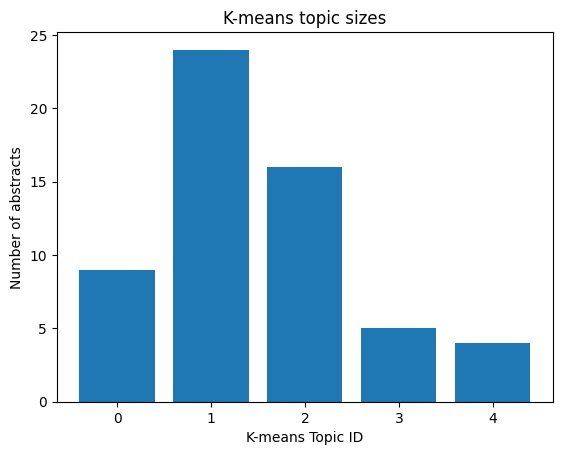

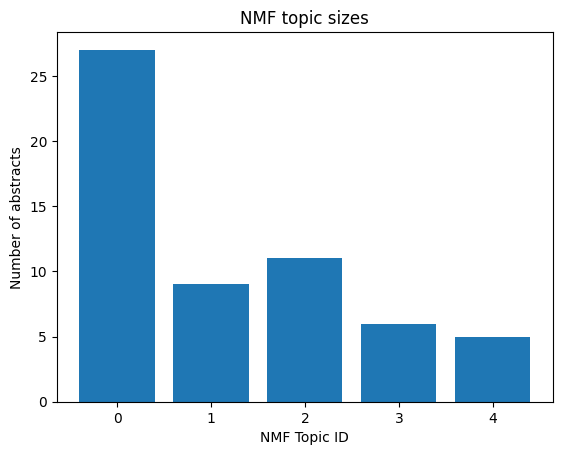

In [12]:
# topic counts for K-means
topic_counts_km = df["topic_kmeans"].value_counts().sort_index()

plt.bar(topic_counts_km.index, topic_counts_km.values)
plt.xlabel("K-means Topic ID")
plt.ylabel("Number of abstracts")
plt.title("K-means topic sizes")

plt.savefig("topic_sizes.png", dpi=300, bbox_inches="tight")
plt.show()

# topic counts for NMF
topic_counts_nmf = df["topic_nmf"].value_counts().sort_index()

plt.bar(topic_counts_nmf.index, topic_counts_nmf.values)
plt.xlabel("NMF Topic ID")
plt.ylabel("Number of abstracts")
plt.title("NMF topic sizes")

plt.savefig("topic_sizes.png", dpi=300, bbox_inches="tight")
plt.show()


When we look at the topic sizes, K-means spreads the abstracts more evenly across its five groups. This means K-means is basically dividing the papers into clusters that are kind of balanced, without strongly favoring one theme. On the other hand, NMF creates one huge topic and several much smaller ones. This tells us that most of the abstracts talk about one big shared theme (genetic factors in Alzheimer’s disease), while only a few abstracts fall into more specific themes. In other words, we can say that K-means spreads things out evenly, while NMF reveals that most of the papers are really talking about the same big idea, with a few smaller subtopics on the side.